### 1. Argumenty za przyjęciem modelu KNN:


1. **Prostota implementacji**: K-NN to algorytm bazujący na prostym założeniu: obiekty podobne do siebie znajdują się blisko w przestrzeni cech. Nie wymaga on złożonego modelowania matematycznego ani obliczeń wstępnych, co czyni go idealnym do szybkiego prototypowania i testowania.

2. **Wysoka dokładność w specyficznych warunkach**: K-NN może osiągać wysoką dokładność w aplikacjach, gdzie prognozy nie są wymagane często, ale ważna jest ich dokładność. Jest to szczególnie przydatne w przypadkach, gdzie dane są dobrze oznakowane i wolne od szumów, co jest stanem naszych danych.

3. **Skuteczność dla złożonych wzorców**: Algorytm K-NN jest wyjątkowo dobry w rozpoznawaniu skomplikowanych wzorców w danych, takich jak wielowymiarowe cechy chemiczne wina, które mogą być subtelnie powiązane z jakością wina na dyskretnej skali od 1 do 10.

4. **Brak założeń na temat danych**: W przeciwieństwie do innych technik klasyfikacyjnych, K-NN nie wymaga założeń statystycznych dotyczących rozkładu danych. Jest to korzystne w przypadku rzeczywistych, często nieskonsolidowanych zestawów danych, co zwiększa jego uniwersalność i adaptacyjność do różnorodnych zbiorów danych.

5. **Elastyczność w wyborze metryki**: K-NN pozwala na łatwą zmianę metryki dystansu (np. euklidesowa, Manhattan), co umożliwia dostosowanie algorytmu do specyfiki danych wina, które mogą różnić się skalą i naturą. Ta elastyczność jest kluczowa, gdy dane różnią się w zakresie ich skali lub wymagają niestandardowego traktowania dystansu.



### 2. Import bibliotek

In [16]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, label_binarize

# Standard libraries
import math
import logging
from collections import Counter

# Data handling and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn libraries for preprocessing and metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Scikit-learn libraries for model selection
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score

# Scikit-learn libraries for models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Scikit-learn libraries for pipeline
from sklearn.pipeline import make_pipeline

# Imbalanced-learn libraries
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline


from sklearn import metrics
#debugging stuff
from typing import Tuple, Optional, Dict, Any
import logging

import numpy as np
import logging
from typing import Any, Dict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler


# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

### 3. Deklaracja funkcji - pobranie i przeskalowanie danych

In [17]:
def initialize_data(scaler_type: Optional[str] = None) -> Tuple[pd.DataFrame, pd.Series]:
    
    # Pobranie danych z plików .csv
    X = pd.read_csv('wineData.csv')
    y = pd.read_csv('wineRatings.csv')
    y = y.values.ravel()
    
    #Informacje o danych do logów
    logging.info(f"X shape: {X.shape}, y shape: {y.shape}")

    #Przeskalowanie danych przy użyciu obiektu MinMaxScaler
    if scaler_type in ["minmax", "standard"]:
        scaler = MinMaxScaler() if scaler_type == "minmax" else StandardScaler()
        X = scaler.fit_transform(X)
        logging.info(f"Data scaled using {scaler_type} scaler.")
    else:
        logging.info("No scaling applied.")

    return X, y

### 4. Deklaracja funkcji - podział danych, uczenie, hiperparametryzacja i ocena modelu

In [18]:
#Funkcja definiująca strategię próbkowania
def sampling_strategy(y):
    unique, counts = np.unique(y, return_counts=True)
    max_count = max(counts)
    return {class_label: max(int(0.40 * max_count), count) for class_label, count in zip(unique, counts)}

#Funkcja dzieląca dane na zbiór treningowy i testowy oraz nakladająca oversampler
def initialize_and_split_data(scaler_type: str, method: str = 'none') -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    X, y = initialize_data(scaler_type)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    if method == 'smote':
        strategy = sampling_strategy(y_train)
        oversampler = SMOTE(sampling_strategy=strategy, k_neighbors=2, random_state=42)
        X_train, y_train = oversampler.fit_resample(X_train, y_train)
        logging.info(f"Applied {method} to handle class imbalance in the training data.")
    return X_train, X_test, y_train, y_test

#Funkcja ewaluująca model
def cross_validation_and_evaluation(X_train: np.ndarray, y_train: np.ndarray, model: Any, best_params: Dict[str, Any], cv_splits: int = 5, random_state: int = 42) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray, list, Dict[str, Any]]:
    # Set the best parameters for the model
    model.set_params(**best_params)
    pipe = make_pipeline(model)

    # Perform cross-validation
    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    cv_results = cross_validate(pipe, X_train, y_train, cv=kfold, return_train_score=True)
    logging.info(f"Cross-validation results: {cv_results}")


    logging.info(f"Mean accuracy score over all folds: {cv_results['test_score'].mean() * 100:.2f}%")
    logging.info(f"Mean training accuracy score over all folds: {cv_results['train_score'].mean() * 100:.2f}%")
    return cv_results, cv_results['test_score'].mean()

#Funkcja znajująca najlepsze hiperparametry
def optimize_hyperparameters(estimator, X_train: np.ndarray, y_train: np.ndarray, param_grid: Dict[str, Any], n_iter: int = 100, cv_splits: int = 5, random_state: int = 42) -> Dict[str, Any]:
    random_search = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid, n_iter=n_iter, cv= cv_splits, scoring='accuracy', random_state=random_state, n_jobs=-1, verbose=2)
    random_search.fit(X_train, y_train)
    logging.info(f"Best accuracy score: {random_search.best_score_ * 100:.2f}%")
    logging.info(f"Best parameters: {random_search.best_params_}")
    return random_search.best_params_



### 5. Deklaracja funkcji - generacja wykresów

In [19]:
def generate_report(y_test: Any, y_pred: Any) -> Dict[str, Any]:
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    logging.info("Classification report:\n%s", classification_report(y_test, y_pred, zero_division=1))
    logging.info("Confusion matrix:\n%s", confusion_matrix(y_test, y_pred))
    return report

#Funkcja generująca histogram
def plot_histogram(y_test: Any, y_pred: Any, ax: plt.Axes) -> None:
    pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).plot.hist(ax=ax, alpha=0.5)
    ax.set_title('Actual vs Predicted values')
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')
    ax.legend(['Actual', 'Predicted'])

#Funkcja generująca wykres przewidywań vs właściwych ocen wina
def plot_actual_vs_predicted(y_test: Any, y_pred: Any, ax: plt.Axes) -> None:
    pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).plot(ax=ax, marker='o')
    ax.set_title('Actual vs Predicted values')
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.legend(['Actual', 'Predicted'])

#Funkcja generująca raport klasyfikacji
def plot_classification_report(report: Dict[str, Any], ax: plt.Axes) -> None:
    report_df = pd.DataFrame(report).transpose().drop(columns='support')
    report_df.plot(kind='bar', ax=ax)
    ax.set_title('Classification Report Metrics')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.legend(loc='lower right')

#Funkcja generująca macierz pomyłek
def plot_confusion_matrix(cm, classes, ax: plt.Axes) -> None:
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion Matrix')

#Funkcja wywołująca wszystkie wykesy
def display_plots(y_fold_test: np.ndarray, y_pred: np.ndarray, report: Dict[str, Any], cv_results: Dict[str, Any], accuracy_without_optimization: float, accuracy_with_optimization: float) -> None:
    fig, axs = plt.subplots(3, 2, figsize=(16, 16))
    classes = [3, 4, 5, 6, 7, 8]
    plot_actual_vs_predicted(y_fold_test, y_pred, axs[0, 0])
    plot_confusion_matrix(confusion_matrix(y_fold_test, y_pred), classes, axs[0, 1])
    plot_classification_report(report, axs[1, 0])
    plot_histogram(y_fold_test, y_pred, axs[2, 1])
    
    axs[1, 1].plot(cv_results['test_score'], label='Test Score')
    axs[1, 1].plot(cv_results['train_score'], label='Train Score')
    axs[1, 1].set_title('Cross-validation Results with Optimized Hyperparameters')
    axs[1, 1].set_xlabel('Fold Index')
    axs[1, 1].set_ylabel('Accuracy')
    axs[1, 1].legend()

    axs[2, 0].bar(['Without Optimization', 'With Optimization'], [accuracy_without_optimization, accuracy_with_optimization])
    axs[2, 0].set_title('Comparison of Model Performance')
    axs[2, 0].set_ylabel('Mean Accuracy Score')
    
    plt.tight_layout()
    plt.show()

### 6. Część głowna

INFO:root:X shape: (1503, 5), y shape: (1503,)
INFO:root:Data scaled using minmax scaler.
INFO:root:Applied smote to handle class imbalance in the training data.
INFO:root:Data initialization and splitting complete.
INFO:root:Cross-validation results: {'fit_time': array([0.00221848, 0.00853753, 0.        , 0.00197744, 0.        ]), 'score_time': array([0.01887369, 0.02169037, 0.01992774, 0.01618862, 0.01356363]), 'test_score': array([0.74043716, 0.62568306, 0.63561644, 0.65205479, 0.68493151]), 'train_score': array([0.76659822, 0.7761807 , 0.78317373, 0.77154583, 0.77633379])}
INFO:root:Mean accuracy score over all folds: 66.77%
INFO:root:Mean training accuracy score over all folds: 77.48%


Fitting 5 folds for each of 100 candidates, totalling 500 fits


INFO:root:Best accuracy score: 76.14%
INFO:root:Best parameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 2, 'algorithm': 'kd_tree'}
INFO:root:Cross-validation results: {'fit_time': array([0.        , 0.        , 0.00129819, 0.        , 0.        ]), 'score_time': array([0.        , 0.00593257, 0.        , 0.00612545, 0.00505376]), 'test_score': array([0.80601093, 0.71857923, 0.78082192, 0.7369863 , 0.79178082]), 'train_score': array([1., 1., 1., 1., 1.])}
INFO:root:Mean accuracy score over all folds: 76.68%
INFO:root:Mean training accuracy score over all folds: 100.00%
INFO:root:Classification report:
              precision    recall  f1-score   support

           3       0.17      0.50      0.25         2
           4       0.14      0.15      0.15        13
           5       0.69      0.68      0.68       120
           6       0.59      0.56      0.58       114
           7       0.59      0.56      0.57        52
           8       0.00      1.00      0.00         0

    

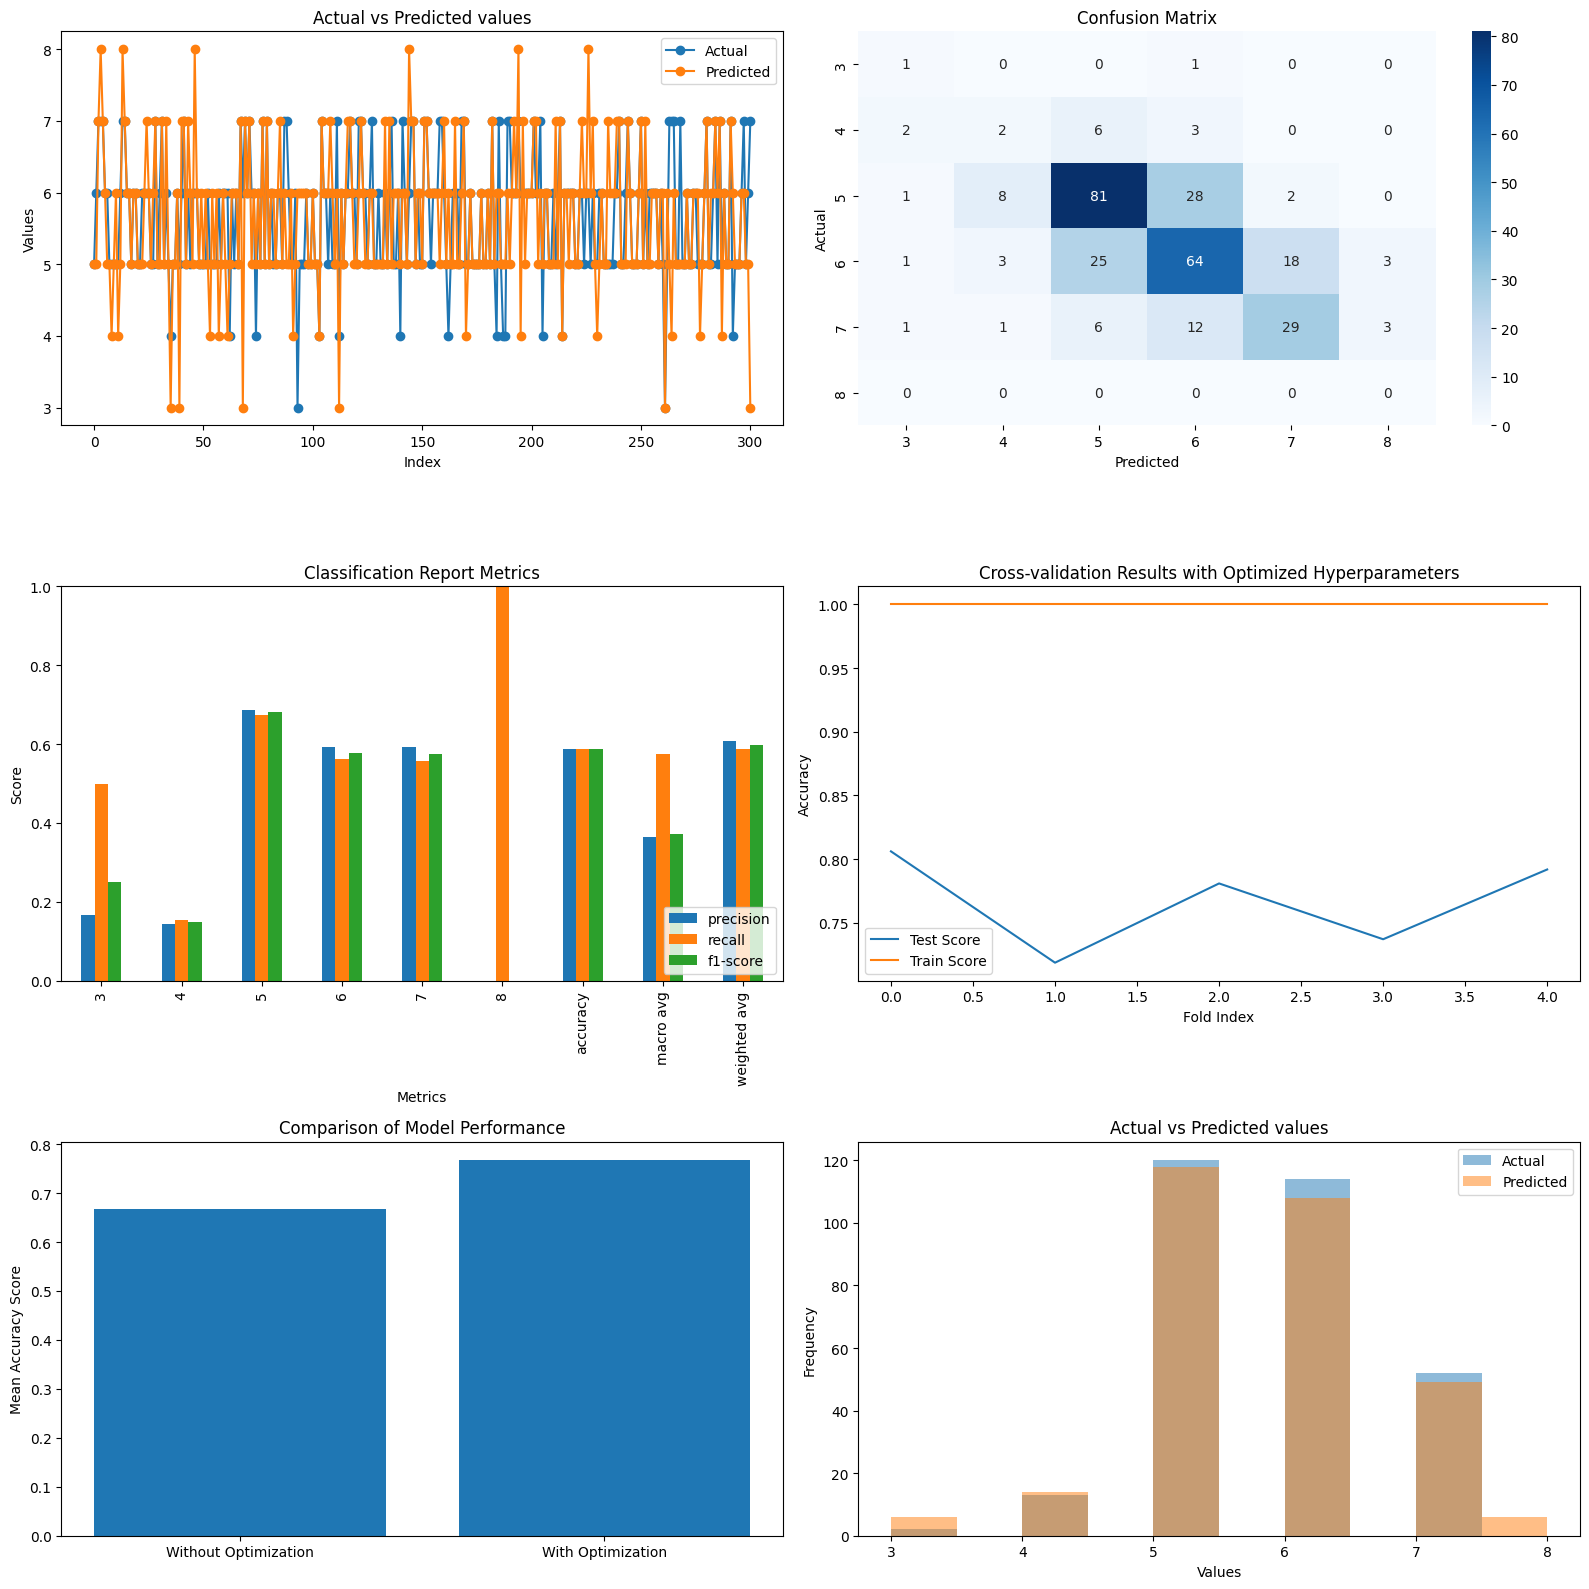

In [20]:
def knn_main():
    try:
        #Podział danych na zbior testowy i treningowy
        X_train, X_test, y_train, y_test = initialize_and_split_data("minmax", 'smote')
        logging.info("Data initialization and splitting complete.")

        #Utworzenie obiektu modelu
        knn = KNeighborsClassifier()

        #Wytrenowanie i wstepna ocena modelu
        best_params = {}
        cv_results, accuracy_without_optimization = cross_validation_and_evaluation(X_train, y_train, knn, best_params)

        #Hiperparametryzacja
        param_grid = {
            'n_neighbors': range(1, 21),
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'p': [1, 2]
        }
        estimator = KNeighborsClassifier()
        best_params = optimize_hyperparameters(estimator, X_train, y_train, param_grid)

        #Walidacja krzyżowa modelu ze zoptymalizowanymi hiperparametrami
        cv_resultsOPT, accuracy_with_optimization = cross_validation_and_evaluation(X_train, y_train, knn, best_params)

        #Ponowne wyktrenowanie modelu, ale ze zoptymalizowanymi hiperparametrami
        knn.set_params(**best_params)
        knn.fit(X_train, y_train)

        #Predykcje na zbiorze testowym
        y_pred_optimized = knn.predict(X_test)

        #Generacja raportu dla modelu
        report_optimized = generate_report(y_test, y_pred_optimized)

        #Generacja wykresów dla modelu
        display_plots(y_test, y_pred_optimized, report_optimized, cv_resultsOPT, accuracy_without_optimization, accuracy_with_optimization)

    except Exception as e:
        logging.error("An error occurred during model evaluation and plotting.", exc_info=True)

if __name__ == "__main__":
    knn_main()

### 6. Podsumowanie

Model uzyskuje słabe wyniki, jego dokładność po hiperparametryzacji, której wpływ widac w wynikach modelu, wynosi jedynie 57%. Wypada najgorzej ze wszystkich modeli, widac bardzo wyraźnie oznaki przetrenowania.